In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import sys
sys.path.append('../')
import geometry
from geometry import geometry

In [5]:
def make_spot(z, phi, rho):

    h = z * jnp.cos(phi)
    k = z * jnp.sin(phi)
    a = rho
    b = rho * jnp.sqrt(1 - z**2)
    theta = jnp.pi/2 + phi

    return {'center': jnp.array([h, k]), 'a': a, 'b': b, 'theta': theta}

def make_planet(z, phi, r):

    h = z * jnp.cos(phi)
    k = z * jnp.sin(phi)

    return {'center': jnp.array([h, k]), 'a': r, 'b': r, 'theta': 0.0}

def add_matrix_form(spot):

    spot['matrix'] = matrix_form(spot)
    return spot

uniform = lambda a, b, n: np.random.rand(n) * (b - a) + a

np.random.seed(3009)

nspots = 30
sqz = uniform(0.0, 1.0, nspots)
z = jnp.sqrt(sqz)
theta = uniform(0, 2 * np.pi, nspots)
rho = uniform(0.1, 0.3, nspots)

spots = jax.vmap(make_spot)(z, theta, rho)

nplanets = 3
sqz = uniform(0.0, 1.0, nplanets)
z = jnp.sqrt(sqz)
theta = uniform(0, 2 * np.pi, nplanets)
r = uniform(0.2, 0.4, nplanets)

planets = jax.vmap(make_planet)(z, theta, r)

spots_and_planets = jax.tree_map(
        lambda a, b: jnp.concatenate([a, b]), 
        spots, 
        planets
)

spot_dicts = [{
        'a':spots['a'][i], 
        'b':spots['b'][i], 
        'center':spots['center'][i], 
        'theta':spots['theta'][i],
    } for i in range(len(spots['a']))]

planet_dicts = [{
        'a':planets['a'][i], 
        'b':planets['b'][i], 
        'center':planets['center'][i], 
        'theta':planets['theta'][i],
    } for i in range(len(planets['a']))]

spots_and_planets_dicts = [{
        'a':spots_and_planets['a'][i], 
        'b':spots_and_planets['b'][i], 
        'center':spots_and_planets['center'][i], 
        'theta':spots_and_planets['theta'][i],
    } for i in range(len(spots_and_planets['a']))]

In [9]:
interior, planet_spot, plimb, slimb = geometry.build_geometry(spots, planets)

(-1.5, 1.5)

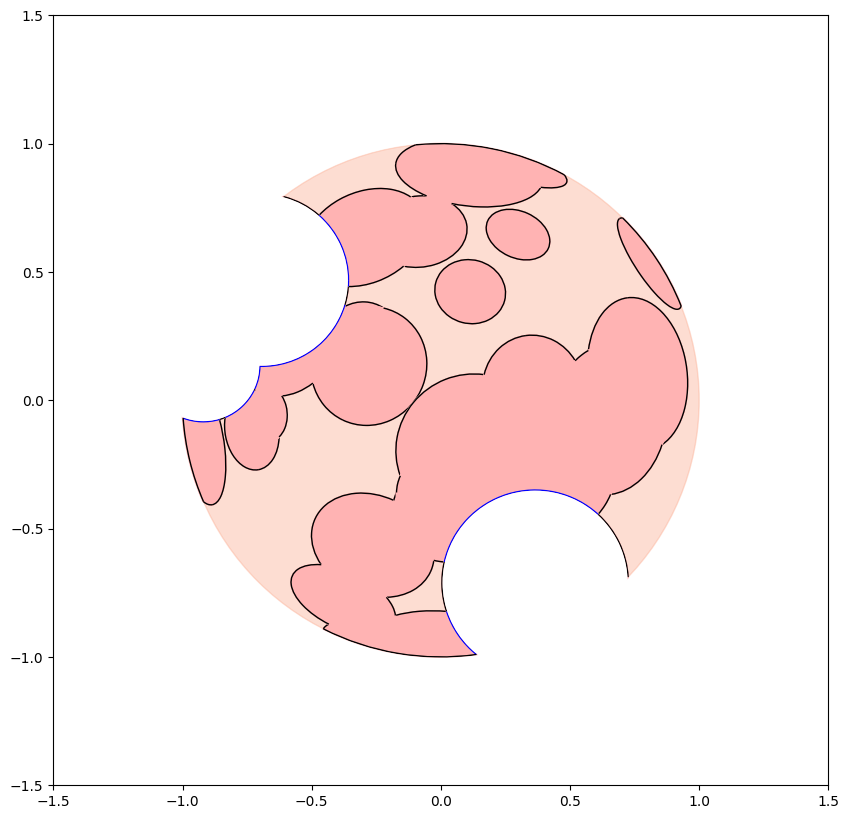

In [10]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Ellipse, Circle

fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

def plot_arcs(ax, ellipses, arcs, color='g', alpha=1.0, plot_filled_ellipse=False):

    arcsets = arcs
    for i, (ellipse, arcset) in enumerate(zip(ellipses, arcsets)):

        if plot_filled_ellipse:
            for e in ellipse:
                ax.add_patch(Ellipse(
                    ellipse['center'], 
                    ellipse['a'] * 2, 
                    ellipse['b'] * 2, 
                    angle=ellipse['theta'] * 180 / np.pi, 
                    fill=True,
                    color=(1.0, 0.7, 0.7),
                    alpha=1.0
                ))
            
        for a in arcset:
            if ~jnp.isnan(a[0]):
                ax.add_patch(Arc(
                    ellipse['center'], 
                    ellipse['a'] * 2, 
                    ellipse['b'] * 2, 
                    angle=ellipse['theta'] * 180 / np.pi, 
                    theta1=a[0] * 180 / np.pi, 
                    theta2=a[1] * 180 / np.pi,
                    color=color,
                    linewidth=1,
                    alpha=alpha
                ))

ax.add_patch(Circle(
    (0.0, 0.0),
    1.0,
    fill=True,
    color=plt.cm.Reds(0.3),
    alpha=0.4
))

plot_arcs(
    ax, 
    spots_and_planets_dicts, 
    interior, 
    'k', 
    plot_filled_ellipse=True
)

plot_arcs(ax, planet_dicts, planet_spot, 'b')

for circ in planet_dicts:
    ax.add_patch(Circle(
        circ['center'], 
        circ['a'] - 0.005, 
        fill=True,
        color = 'w',
        alpha=1.0,
    ))

star = {'center': [0.0, 0.0], 'a': 1.0, 'b': 1.0, 'theta':0.0}
plot_arcs(ax, [star], [slimb], 'k')

ax.add_patch(Circle(
    (0.0, 0.0),
    1.0 + 0.274,
    fill=False,
    linewidth=100,
    alpha=1.0,
    color='w'
))

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)